# SOM 군집화

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn as sk
import sklearn.cluster as cluster

x=np.random.randn(10000)
y=np.random.randn(10000)

df=pd.DataFrame({"x":x,"y":y})

df["dis"]=df["x"]**2+df["y"]**2
df["cla"]=df["dis"].apply(lambda x:1 if 0.5<x<1.0 else 2 if 3<x<4 else 0)
df["cla"].value_counts()
df=df[df["cla"]!=0]

<AxesSubplot:xlabel='x', ylabel='y'>

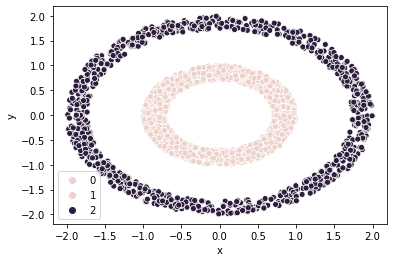

In [2]:
# sns.scatterplot(df["x"],df["y"])
sns.scatterplot(df["x"],df["y"],hue=df["cla"].values)

In [ ]:
# !pip install som-learn

In [ ]:
from somlearn import SOM
CLUSTERER = SOM(n_columns=1, n_rows=2, gridtype='hexagonal', random_state=70)

CLUSTERER.fit_predict(df)

df["pred"]=y_pred
sns.scatterplot(df["x"],df["y"],hue=df["pred"].values)

## (비교)kmeans 군집화

<AxesSubplot:xlabel='x', ylabel='y'>

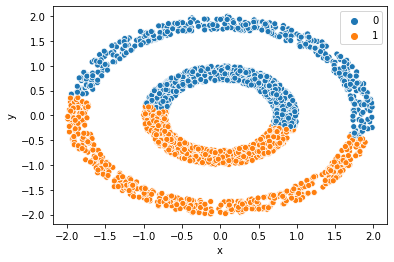

In [17]:
model=cluster.KMeans(2)
model.fit(df[["x","y"]])
df["pre"]=model.predict(df[["x","y"]])
sns.scatterplot(x =df["x"], y =df["y"],hue=df["pre"].values)

# LSTM

In [ ]:
from numpy import array
from keras.models import Sequential
from keras.layers import Dense, LSTM
 
x = array([[1,2,3], [2,3,4], [3,4,5], [4,5,6], [5,6,7],
            [6,7,8], [7,8,9], [8,9,10], [9,10,11], [10,11,12],
            [20,30,40], [30,40,50], [40,50,60]])
y = array([4,5,6,7,8,9,10,11,12,13,50,60,70])
 
print(x.shape) # (13,3)
print(y.shape) # (13,)
x = x.reshape((x.shape[0], x.shape[1], 1))
print(x.shape) # (13,3,1)
 
model = Sequential()
model.add(LSTM(20, activation = 'relu', input_shape=(3,1)))
model.add(Dense(5))
model.add(Dense(1))
 
model.compile(optimizer='adam', loss='mse')
 
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='loss', patience=100, mode='auto')
# loss값을 모니터해서 과적합이 생기면 100번 더 돌고 끊음
# mode=auto loss면 최저값이100번정도 반복되면 정지, acc면 최고값이 100번정도 반복되면 정지
# mode=min, mode=max
model.fit(x, y, epochs=1000, batch_size=1, verbose=2, callbacks=[early_stopping])
 
x_input = array([25,35,45]) # predict용
x_input = x_input.reshape((1,3,1))
 
yhat = model.predict(x_input)
print(yhat)


# 잔차의 등분산성 검정(Brown-Forsythe 검정)

선형 회귀 모형의 가정 중에는 오차의 등분산성이 있어요.<br>
오차의 등분산성이란 오차의 분산이 회귀 모형에 포함된 설명 변수의 값과 상관없이 일정하다는 뜻입니다. 

1) 선형 모형을 적합한다.

2) 적합한 선형 모형을 이용하여 잔차를 구한다.

3) 적합에 사용한 설명 변수를 이용하여 잔차를 두 그룹으로 나눈다.

4) 각 그룹에서 잔차의 중간값을 구하고 잔차와 중간값 차이의 평균을 구한다.

5) 두 그룹에서 계산한 차이를 이용하여 이 표본(Two sample) t 테스트를 수행한다.

In [ ]:
import pandas as pd
import numpy as np
 
from scipy.stats import t
from statsmodels.formula.api import ols

In [ ]:
fit = ols('Work_hours ~ Lot_size',data=df).fit() ## 단순선형회귀모형 적합
 
## 그룹별 잔차를 구한다.
 
def get_median(x):
    ## 중간값을 계산하는 함수
    x = sorted(x)
    mid_index = len(x)//2
    return (x[mid_index]+x[~mid_index])/2
 
median_lot_size = get_median(df['Lot_size']) ## Lot_size의 중앙값
 
g1 = [i for i in df['Lot_size'].index if df['Lot_size'][i] <= median_lot_size] ## 중간값이하의 데이터는 그룹 1로 한다.
g2 = [i for i in df['Lot_size'].index if df['Lot_size'][i] > median_lot_size] ## 중간값을 초과하는 데이터는 값은 그룹 2로한다.
 
e1 = [] ## 그룹 1의 잔차
e2 = [] ## 그룹 2의 잔차
for i in df['Lot_size'].index:
    fitted_value = fit.params.Intercept + fit.params.Lot_size*df['Lot_size'][i] ## 해당 Lot_size에 대한 Work_hours의 추정값
    resid = df['Work_hours'][i] - fitted_value ## 잔차
    if i in g1:
        e1.append(resid)
    else:
        e2.append(resid)
        
median_e1 = get_median(e1) ## 그룹 1 잔차 중앙값
median_e2 = get_median(e2) ## 그룹 2 잔차 중앙값
 
d1 = [] ## 그룹 1 잔차와 잔차 중앙값의 차이
d2 = [] ## 그룹 2 잔차와 잔차 중앙값의 차이
for e in e1:
    d1.append(abs(e-median_e1))
for e in e2:
    d2.append(abs(e-median_e2))
    
# 검정통계량 계산
pooled_var_num = sum([(x-np.mean(d1))**2 for x in d1]) + sum([(x-np.mean(d2))**2 for x in d2])
pooled_var_denom = len(df)-2 ## 자유도
pooled_var = pooled_var_num/pooled_var_denom ## pooled variance
s = np.sqrt(pooled_var) ## standard deviation of pooled variance
 
t_bf = (np.mean(d1)-np.mean(d2))/(s*np.sqrt(1/len(d1)+1/len(d2))) ## 검정 통계량

- 위 코드를 실행하고 검정 통계량의 값이 얼마인지 확인합니다.
- 양측 검정을 수행할 것이므로 검정 통계량의 절대값을 보아야합니다. 

In [ ]:
abd(t_bf) # 1.316

- 그리고 유의수준 5%에서 자유도가 23(=25-2)인 t 분포의 왼쪽 꼬리확률이 0.025에 해당하는 값(절대값)을 구합니다.

In [ ]:
## 기각역
alpha = 0.05 ## 유의수준
critical_value = t.ppf(1-alpha/2,len(df)-2) ## 2.069


검정 통계량 값 1.316이 꼬리 값 2.069보다 작으므로 귀무가설을 기각할 수 없습니다. 즉, 두 그룹의 평균의 차이가 없다고 할 수 있으며 이는 설명 변수에 따라 분산이 변하지 않는다는 뜻입니다. 즉, 오차의 등분산성을 위배하지 않는다고 결론을 내릴 수 있습니다.

# 라이브러리 정리(ppp)

In [25]:
!pip install matplotlip

In [27]:
from matplotlip import test_fn2

test_fn2.test_function()